## Kaggle Environment Note

**Important:** This notebook was originally developed and executed on **Kaggle** with GPU acceleration. When running locally, you may encounter differences in:

1. **File paths** - Kaggle uses `/kaggle/input/` and `/kaggle/working/` directories
2. **GPU availability** - Local execution may use CPU or different GPU memory constraints
3. **Library versions** - Some packages may have version differences

To run this notebook locally:
1. Adjust file paths to match your local directory structure
2. Ensure you have sufficient GPU memory or adjust batch sizes accordingly
3. Install required packages from `requirements.txt` in the project root

The production refactored version of this training pipeline is available in `src/models/trainer.py` for consistent local execution.

In [5]:
# ============================================================================
# PHASE 7: LAYOUTLMV3 FINE-TUNING FOR INVOICE EXTRACTION
# ============================================================================

print("="*80)
print("PHASE 7: MODEL TRAINING")
print("="*80)

PHASE 7: MODEL TRAINING


In [6]:
# ----------------------------------------------------------------------------
# STEP 1: Install and Import Libraries
# ----------------------------------------------------------------------------
print("\n[STEP 1] Installing and importing libraries...")

# Install required packages
!pip install -q transformers datasets evaluate seqeval accelerate

import os
import numpy as np
import torch
from datasets import load_from_disk
from transformers import (
    LayoutLMv3ForTokenClassification,
    LayoutLMv3Processor,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from evaluate import load as load_metric
import json
from tqdm.auto import tqdm

print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


[STEP 1] Installing and importing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True
✓ GPU: Tesla T4
✓ GPU Memory: 15.83 GB


In [7]:
# ----------------------------------------------------------------------------
# STEP 2: Load Datasets
# ----------------------------------------------------------------------------
print("\n[STEP 2] Loading datasets...")

# Update this path to match your Kaggle dataset name
dataset_path = "/kaggle/input/invoice-extraction-layoutlm-dataset/layoutlm_dataset"

train_dataset = load_from_disk(f"{dataset_path}/train")
val_dataset = load_from_disk(f"{dataset_path}/val")
test_dataset = load_from_disk(f"{dataset_path}/test")

print(f"✓ Train set: {len(train_dataset)} samples")
print(f"✓ Val set: {len(val_dataset)} samples")
print(f"✓ Test set: {len(test_dataset)} samples")

# Verify sample structure
sample = train_dataset[0]
print(f"\n--- Sample Structure ---")
print(f"Keys: {list(sample.keys())}")
print(f"pixel_values shape: {np.array(sample['pixel_values']).shape}")
print(f"input_ids length: {len(sample['input_ids'])}")
print(f"labels length: {len(sample['labels'])}")


[STEP 2] Loading datasets...
✓ Train set: 5549 samples
✓ Val set: 694 samples
✓ Test set: 694 samples

--- Sample Structure ---
Keys: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels']
pixel_values shape: (3, 224, 224)
input_ids length: 512
labels length: 512


In [8]:
# ----------------------------------------------------------------------------
# STEP 3: Define Label Schema
# ----------------------------------------------------------------------------
print("\n[STEP 3] Setting up label schema...")

# Define label mapping (same as Phase 5)
id2label = {
    0: "O",
    1: "B-invoice_number",
    2: "I-invoice_number",
    3: "B-invoice_date",
    4: "I-invoice_date",
    5: "B-buyer_address",
    6: "I-buyer_address",
    7: "B-seller_address",
    8: "I-seller_address",
    9: "B-product_description",
    10: "I-product_description",
    11: "B-product_quantity",
    12: "B-product_unit_price",
    13: "B-product_total_price",
    14: "B-payment_total",
    15: "B-payment_sub_total"
}

label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

print(f"✓ Number of labels: {num_labels}")
print(f"✓ Label schema defined")


[STEP 3] Setting up label schema...
✓ Number of labels: 16
✓ Label schema defined


In [9]:
# ----------------------------------------------------------------------------
# STEP 4: Initialize Model
# ----------------------------------------------------------------------------
print("\n[STEP 4] Initializing LayoutLMv3 model...")

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✓ Model loaded: layoutlmv3-base")
print(f"✓ Device: {device}")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


[STEP 4] Initializing LayoutLMv3 model...


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: layoutlmv3-base
✓ Device: cuda
✓ Model parameters: 125,929,872
✓ Trainable parameters: 125,929,872


In [16]:
# ----------------------------------------------------------------------------
# STEP 5: Define Evaluation Metrics
# ----------------------------------------------------------------------------
print("\n[STEP 5] Setting up evaluation metrics...")

seqeval_metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval_metric.compute(predictions=true_predictions, references=true_labels)
    
    # 1. Create the main flat dictionary
    report = {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
    
    # 2. Add the per-entity metrics as individual keys
    # This ensures the Trainer sees them as flat values, not nested dicts
    for key, value in results.items():
        if key not in ["overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]:
            # Flatten the nested seqeval dict (extracting just the f1 for that entity)
            if isinstance(value, dict):
                report[f"{key}_f1"] = value["f1"]
            else:
                report[key] = value

    return report


[STEP 5] Setting up evaluation metrics...


In [11]:
# ----------------------------------------------------------------------------
# STEP 6: Define Training Arguments (IMPROVED - Anti-Overfitting)
# ----------------------------------------------------------------------------
print("\n[STEP 6] Configuring training arguments...")

training_args = TrainingArguments(
    output_dir="./layoutlm_invoice_model_v2",  # New version
    
    # Training duration
    num_train_epochs=15,               # Reduced from 25 (prevent overfitting)
    
    # Batch sizes
    per_device_train_batch_size=4,     # Optimal for T4 GPU
    per_device_eval_batch_size=8,      # Can be larger (no gradients)
    
    # Learning rate & schedule (IMPROVED)
    learning_rate=1e-5,                # ← Reduced from 5e-5 (more stable)
    lr_scheduler_type="linear",        # ← Changed from cosine (faster decay)
    warmup_ratio=0.1,                 # ← Reduced from 0.1 (shorter warmup)
    
    # Regularization (STRONGER)
    weight_decay=0.1,                 # ← Increased from 0.01 (5x stronger)
    
    # Evaluation & Checkpointing
    eval_strategy="steps",
    eval_steps=200,                    # Evaluate every 200 steps
    save_strategy="steps",
    save_steps=200,                    # Save every 200 steps
    save_total_limit=5,                # Keep last 5 checkpoints
    
    # Best model selection (CRITICAL)
    load_best_model_at_end=True,      # Load best checkpoint at end
    metric_for_best_model="f1",       # Use F1 to determine best
    greater_is_better=True,            # Higher F1 = better
    
    # Logging
    logging_dir="./logs_v2",
    logging_strategy="steps",
    logging_steps=50,                  # ← More frequent (was 100)
    logging_first_step=True,           # ← Log immediately
    report_to="none",
    
    # Performance optimizations
    fp16=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    
    # Reproducibility
    seed=42,
)

print("✓ Training arguments configured")

print(f"\n{'='*70}")
print(f"{'TRAINING CONFIGURATION':^70}")
print(f"{'='*70}")

print(f"\n{'Basic Settings':-^70}")
print(f"  Max epochs: {training_args.num_train_epochs}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Eval batch size: {training_args.per_device_eval_batch_size}")

print(f"\n{'Learning Rate (IMPROVED)':-^70}")
print(f"  Base LR: {training_args.learning_rate:.0e} (reduced from 5e-5)")
print(f"  Scheduler: {training_args.lr_scheduler_type} (changed from cosine)")
print(f"  Warmup: {training_args.warmup_ratio*100:.0f}% (reduced from 10%)")

print(f"\n{'Regularization (STRONGER)':-^70}")
print(f"  Weight decay: {training_args.weight_decay} (increased 5x)")

print(f"\n{'Evaluation & Saving':-^70}")
print(f"  Eval every: {training_args.eval_steps} steps")
print(f"  Save every: {training_args.save_steps} steps")
print(f"  Keep checkpoints: {training_args.save_total_limit}")
print(f"  Best model metric: {training_args.metric_for_best_model}")



[STEP 6] Configuring training arguments...
✓ Training arguments configured

                        TRAINING CONFIGURATION                        

----------------------------Basic Settings----------------------------
  Max epochs: 15
  Train batch size: 4
  Eval batch size: 8

-----------------------Learning Rate (IMPROVED)-----------------------
  Base LR: 1e-05 (reduced from 5e-5)
  Scheduler: SchedulerType.LINEAR (changed from cosine)
  Warmup: 10% (reduced from 10%)

----------------------Regularization (STRONGER)-----------------------
  Weight decay: 0.1 (increased 5x)

-------------------------Evaluation & Saving--------------------------
  Eval every: 200 steps
  Save every: 200 steps
  Keep checkpoints: 5
  Best model metric: f1


In [12]:
# ----------------------------------------------------------------------------
# STEP 7: Initialize Data Collator
# ----------------------------------------------------------------------------
print("\n[STEP 7] Setting up data collator...")

from transformers import default_data_collator

# Use default collator - perfect for pre-processed data
data_collator = default_data_collator

print("✓ Data collator initialized")
print("  Using default_data_collator (handles all LayoutLMv3 features)")

from transformers import EarlyStoppingCallback

# Stop if F1 doesn't improve for 5 evaluations (500 steps)
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)


[STEP 7] Setting up data collator...
✓ Data collator initialized
  Using default_data_collator (handles all LayoutLMv3 features)


In [13]:
# ----------------------------------------------------------------------------
# STEP 8: Class Weights from Known Distribution
# ----------------------------------------------------------------------------
print("\n[STEP 8] Setting up class weights...")

import torch
import numpy as np

# Based on your Phase 5 statistics + token-level estimates
# Approximate token counts (estimated from sample coverage)
label_token_counts = {
    0: 220000,   # O (81.3% of all tokens)
    1: 3500,     # B-invoice_number (~2 tokens per 24% of samples)
    2: 1700,     # I-invoice_number
    3: 5000,     # B-invoice_date (~2 tokens per 36.4% of samples)
    4: 2500,     # I-invoice_date
    5: 7400,     # B-buyer_address (~2 tokens per 53.6% of samples)
    6: 14500,    # I-buyer_address (~6 tokens per 34.9% of samples)
    7: 6000,     # B-seller_address
    8: 14000,    # I-seller_address
    9: 8000,     # B-product_description
    10: 12900,   # I-product_description
    11: 3300,    # B-product_quantity
    12: 2200,    # B-product_unit_price
    13: 2200,    # B-product_total_price
    14: 4200,    # B-payment_total
    15: 4000,    # B-payment_sub_total
}

total_tokens = sum(label_token_counts.values())
num_classes = len(id2label)

# Calculate inverse frequency weights with SQUARE ROOT smoothing
class_weights = []
for class_id in range(num_classes):
    count = label_token_counts[class_id]
    # Adding np.sqrt here is the magic change
    weight = np.sqrt(total_tokens / (num_classes * count)) 
    class_weights.append(weight)

# Normalize
class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"✓ Smoothed 'O' weight: {class_weights[0]:.3f}")
print(f"✓ Smoothed Price weight: {class_weights[12]:.3f}")
print(f"✓ New Weight ratio: {class_weights[12]/class_weights[0]:.1f}x (Down from ~60x)")



[STEP 8] Setting up class weights...
✓ Smoothed 'O' weight: 0.148
✓ Smoothed Price weight: 1.483
✓ New Weight ratio: 10.0x (Down from ~60x)


In [14]:
# ----------------------------------------------------------------------------
# STEP 9: Custom Trainer with Weighted Loss (MULTI-GPU COMPATIBLE)
# ----------------------------------------------------------------------------
print("\n[STEP 9] Initializing trainer...")

from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Get num_labels (handle DataParallel wrapper)
        num_labels = model.module.config.num_labels if hasattr(model, 'module') else model.config.num_labels
        
        # Weighted loss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=-100)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[early_stopping],
)

print("✓ Trainer initialized")
print(f"✓ Training: {len(train_dataset):,} samples")
print(f"✓ Validation: {len(val_dataset):,} samples")
print(f"✓ Using 2x T4 GPUs with weighted loss")


[STEP 9] Initializing trainer...
✓ Trainer initialized
✓ Training: 5,549 samples
✓ Validation: 694 samples
✓ Using 2x T4 GPUs with weighted loss


In [17]:
# ----------------------------------------------------------------------------
# STEP 10: Train Model
# ----------------------------------------------------------------------------
print("\n[STEP 10] Starting training...")
print("="*80)
print("TRAINING IN PROGRESS")
print("="*80)

# Auto-resume if checkpoints exist
import os
if os.path.exists(training_args.output_dir):
    checkpoints = sorted([d for d in os.listdir(training_args.output_dir) 
                         if d.startswith('checkpoint-')])
    if checkpoints:
        latest = f"{training_args.output_dir}/{checkpoints[-1]}"
        print(f"Resuming from {checkpoints[-1]}...\n")
        train_result = trainer.train(resume_from_checkpoint=latest)
    else:
        train_result = trainer.train()
else:
    train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Runtime: {train_result.metrics['train_runtime']/60:.1f} minutes")
print(f"Final loss: {train_result.metrics['train_loss']:.4f}")


[STEP 10] Starting training...
TRAINING IN PROGRESS
Resuming from checkpoint-200...



/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Buyer Address,Invoice Date,Invoice Number,Payment Sub Total,Payment Total,Product Description,Product Quantity,Product Total Price,Product Unit Price,Seller Address
400,1.357100,1.247614,0.272164,0.302422,0.286496,0.811274,"{'precision': 0.23255813953488372, 'recall': 0.0715307582260372, 'f1': 0.10940919037199126, 'number': 699}","{'precision': 0.4487704918032787, 'recall': 0.7849462365591398, 'f1': 0.5710560625814864, 'number': 279}","{'precision': 0.3581780538302277, 'recall': 0.9202127659574468, 'f1': 0.5156482861400894, 'number': 188}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 200}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 199}","{'precision': 0.5376344086021505, 'recall': 0.46403712296983757, 'f1': 0.49813200498132, 'number': 862}","{'precision': 0.1311569301260023, 'recall': 0.9308943089430894, 'f1': 0.22991967871485947, 'number': 246}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 164}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 157}","{'precision': 0.08, 'recall': 0.04375, 'f1': 0.05656565656565656, 'number': 640}"
600,1.000700,0.955733,0.391652,0.418272,0.404524,0.851534,"{'precision': 0.19655172413793104, 'recall': 0.0815450643776824, 'f1': 0.11526794742163803, 'number': 699}","{'precision': 0.5301724137931034, 'recall': 0.8817204301075269, 'f1': 0.6621803499327052, 'number': 279}","{'precision': 0.6654676258992805, 'recall': 0.9840425531914894, 'f1': 0.7939914163090128, 'number': 188}","{'precision': 0.34615384615384615, 'recall': 0.225, 'f1': 0.27272727272727276, 'number': 200}","{'precision': 0.4166666666666667, 'recall': 0.20100502512562815, 'f1': 0.2711864406779661, 'number': 199}","{'precision': 0.5091533180778032, 'recall': 0.5162412993039444, 'f1': 0.5126728110599079, 'number': 862}","{'precision': 0.2194871794871795, 'recall': 0.8699186991869918, 'f1': 0.35053235053235055, 'number': 246}","{'precision': 0.4176829268292683, 'recall': 0.8353658536585366, 'f1': 0.556910569105691, 'number': 164}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 157}","{'precision': 0.33856502242152464, 'recall': 0.2359375, 'f1': 0.2780847145488029, 'number': 640}"
800,0.916200,0.836384,0.414771,0.486791,0.447905,0.857174,"{'precision': 0.40431266846361186, 'recall': 0.2145922746781116, 'f1': 0.2803738317757009, 'number': 699}","{'precision': 0.7215568862275449, 'recall': 0.8637992831541219, 'f1': 0.7862969004893964, 'number': 279}","{'precision': 0.7887931034482759, 'recall': 0.973404255319149, 'f1': 0.8714285714285714, 'number': 188}","{'precision': 0.29277566539923955, 'recall': 0.385, 'f1': 0.3326133909287257, 'number': 200}","{'precision': 0.26038781163434904, 'recall': 0.4723618090452261, 'f1': 0.3357142857142857, 'number': 199}","{'precision': 0.5169082125603864, 'recall': 0.4965197215777262, 'f1': 0.5065088757396449, 'number': 862}","{'precision': 0.23307436182019978, 'recall': 0.8536585365853658, 'f1': 0.36617262423714037, 'number': 246}","{'precision': 0.35167464114832536, 'recall': 0.8963414634146342, 'f1': 0.5051546391752578, 'number': 164}","{'precision': 0.2127659574468085, 'recall': 0.12738853503184713, 'f1': 0.1593625498007968, 'number': 157}","{'precision': 0.47300215982721383, 'recall': 0.3421875, 'f1': 0.39709882139619224, 'number': 640}"
1000,0.806200,0.766924,0.456544,0.497248,0.476027,0.871516,"{'precision': 0.38990825688073394, 'recall': 0.24320457796852646, 'f1': 0.29955947136563876, 'number': 699}","{'precision': 0.7538940809968847, 'recall': 0.8673835125448028, 'f1': 0.8066666666666668, 'number': 279}","{'precision': 0.8243243243243243, 'recall': 0.973404255319149, 'f1': 0.8926829268292683, 'number': 188}","{'precision': 0.46206896551724136, 'recall': 0.335, 'f1': 0.3884057971014493, 'number': 200}","{'precision': 0.23903508771929824, 'recall': 0.5477386934673367, 'f1': 0.332824427480916, 'number': 199}","{'precision': 0.5501222493887531, 'recall': 0.5220417633410673, 'f1': 0.5357142

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist


TRAINING COMPLETE!
Runtime: 88.4 minutes
Final loss: 0.6915


Detected 10 entities: ['eval_buyer_address', 'eval_invoice_date', 'eval_invoice_number', 'eval_payment_sub_total', 'eval_payment_total', 'eval_product_description', 'eval_product_quantity', 'eval_product_total_price', 'eval_product_unit_price', 'eval_seller_address']


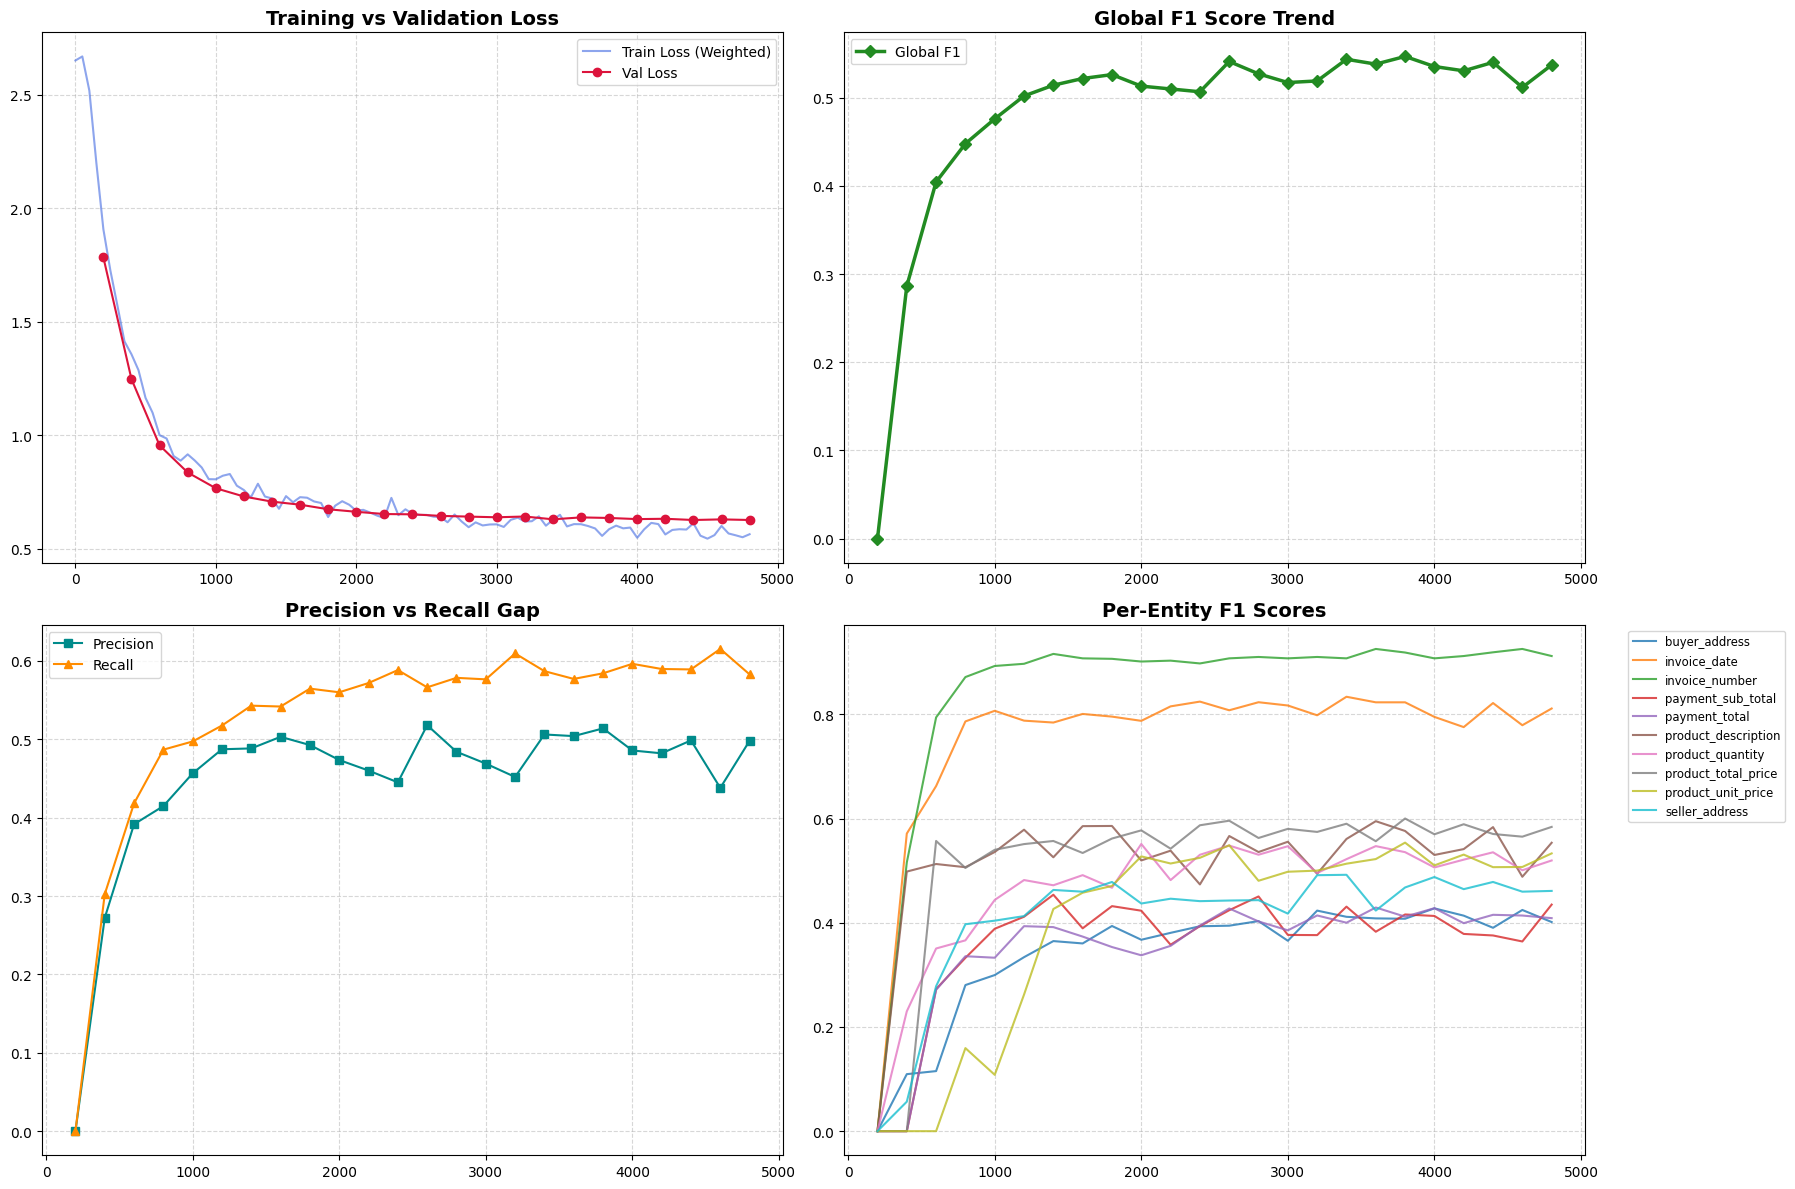

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD DATA
PATH = "./layoutlm_invoice_model_v2/checkpoint-4800/trainer_state.json"

with open(PATH, 'r') as f:
    state = json.load(f)

df = pd.DataFrame(state['log_history'])

# 2. PREPROCESS
train_df = df[df['loss'].notna()].copy()
eval_df = df[df['eval_loss'].notna()].copy()

# Helper to extract F1 from seqeval dictionary
def extract_f1(val):
    if isinstance(val, dict):
        return val.get('f1', 0)
    return val

# --- AUTOMATIC COLUMN DETECTION ---
# We want everything starting with 'eval_' EXCEPT the global stats
global_metrics = ['eval_loss', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
entity_cols = [c for c in eval_df.columns if c.startswith('eval_') and c not in global_metrics]

# Apply flattening to the detected columns
for col in entity_cols:
    eval_df[col] = eval_df[col].apply(extract_f1)

print(f"Detected {len(entity_cols)} entities: {entity_cols}")

# 3. PLOTTING
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Plot 1: Loss Curves
axes[0].plot(train_df['step'], train_df['loss'], label='Train Loss (Weighted)', alpha=0.6, color='royalblue')
axes[0].plot(eval_df['step'], eval_df['eval_loss'], label='Val Loss', marker='o', color='crimson')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Global F1 Score
axes[1].plot(eval_df['step'], eval_df['eval_f1'], label='Global F1', marker='D', color='forestgreen', linewidth=2.5)
axes[1].set_title('Global F1 Score Trend', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Precision vs Recall (The Over-Penalization Gap)
axes[2].plot(eval_df['step'], eval_df['eval_precision'], label='Precision', marker='s', color='darkcyan')
axes[2].plot(eval_df['step'], eval_df['eval_recall'], label='Recall', marker='^', color='darkorange')
axes[2].set_title('Precision vs Recall Gap', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Per-Entity F1 Breakdown
for col in entity_cols:
    # Only plot if there's actual data in the column
    if eval_df[col].dropna().any():
        axes[3].plot(eval_df['step'], eval_df[col], label=col.replace('eval_', ''), alpha=0.8)

axes[3].set_title('Per-Entity F1 Scores', fontsize=14, fontweight='bold')
axes[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
axes[3].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [20]:
# ----------------------------------------------------------------------------
# STEP 11: Evaluate on Validation Set
# ----------------------------------------------------------------------------
print("\n[STEP 10] Evaluating on validation set...")

val_results = trainer.evaluate()

print(f"\n--- Validation Results ---")
print(f"Validation loss: {val_results['eval_loss']:.4f}")
print(f"Precision: {val_results['eval_precision']:.4f}")
print(f"Recall: {val_results['eval_recall']:.4f}")
print(f"F1 Score: {val_results['eval_f1']:.4f}")
print(f"Accuracy: {val_results['eval_accuracy']:.4f}")


[STEP 10] Evaluating on validation set...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a4ffd5ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a4ffd5ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


--- Validation Results ---
Validation loss: 0.6359
Precision: 0.5139
Recall: 0.5842
F1 Score: 0.5468
Accuracy: 0.8852


In [21]:
# ----------------------------------------------------------------------------
# STEP 12: Evaluate on Test Set
# ----------------------------------------------------------------------------
print("\n[STEP 11] Evaluating on test set...")

# Temporarily change eval dataset to test set
trainer.eval_dataset = test_dataset
test_results = trainer.evaluate()

print(f"\n--- Test Results ---")
print(f"Test loss: {test_results['eval_loss']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")

# Restore val dataset
trainer.eval_dataset = val_dataset


[STEP 11] Evaluating on test set...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a4ffd5ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a4ffd5ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


--- Test Results ---
Test loss: 0.6448
Precision: 0.4921
Recall: 0.5723
F1 Score: 0.5292
Accuracy: 0.8826


In [22]:
# ----------------------------------------------------------------------------
# STEP 13: Detailed Predictions Analysis
# ----------------------------------------------------------------------------
print("\n[STEP 12] Analyzing predictions on test set...")

# Get predictions
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Analyze per-field performance
field_stats = {label: {'correct': 0, 'total': 0} for label in id2label.values() if label != 'O'}

for pred_seq, label_seq in zip(predictions, true_labels):
    for pred, label in zip(pred_seq, label_seq):
        if label == -100 or label == 0:  # Skip padding and 'O'
            continue
        
        label_name = id2label[label]
        field_stats[label_name]['total'] += 1
        
        if pred == label:
            field_stats[label_name]['correct'] += 1

print("\n--- Per-Field Accuracy ---")
print(f"{'Field':<30} {'Accuracy':<10} {'Count'}")
print("-" * 50)

for field, stats in sorted(field_stats.items(), key=lambda x: x[1]['total'], reverse=True):
    if stats['total'] > 0:
        accuracy = stats['correct'] / stats['total']
        print(f"{field:<30} {accuracy:<10.2%} {stats['total']}")


[STEP 12] Analyzing predictions on test set...

--- Per-Field Accuracy ---
Field                          Accuracy   Count
--------------------------------------------------
I-seller_address               85.45%     818
B-product_description          70.65%     787
I-buyer_address                76.83%     738
I-product_description          87.53%     738
B-buyer_address                50.13%     393
B-seller_address               57.10%     331
B-product_quantity             71.12%     277
B-invoice_date                 85.11%     262
B-payment_total                52.61%     211
B-payment_sub_total            49.75%     197
B-product_unit_price           69.23%     182
B-product_total_price          82.74%     168
B-invoice_number               100.00%    146
I-invoice_date                 0.00%      6


In [26]:
# ----------------------------------------------------------------------------
# STEP 14: Save Model
# ----------------------------------------------------------------------------
print("\n[STEP 14] Saving final model...")

# Save model and tokenizer
output_model_dir = "./final_invoice_model"
trainer.save_model(output_model_dir)

print(f"✓ Model saved to: {output_model_dir}")

# Save training metrics
metrics = {
    "train_loss": train_result.metrics['train_loss'],
    "train_runtime": train_result.metrics['train_runtime'],
    "val_f1": val_results['eval_f1'],
    "val_precision": val_results['eval_precision'],
    "val_recall": val_results['eval_recall'],
    "test_f1": test_results['eval_f1'],
    "test_precision": test_results['eval_precision'],
    "test_recall": test_results['eval_recall'],
}

with open(f"{output_model_dir}/metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Metrics saved to: {output_model_dir}/metrics.json")


[STEP 14] Saving final model...
✓ Model saved to: ./final_invoice_model
✓ Metrics saved to: ./final_invoice_model/metrics.json


In [23]:
# ----------------------------------------------------------------------------
# STEP 15: Sample Predictions Visualization
# ----------------------------------------------------------------------------
print("\n[STEP 14] Visualizing sample predictions...")

# Get 5 random test samples
import random
sample_indices = random.sample(range(len(test_dataset)), min(5, len(test_dataset)))

print("\n--- Sample Predictions ---\n")

for idx in sample_indices:
    sample = test_dataset[idx]
    
    # Get prediction
    inputs = {
        'pixel_values': torch.tensor(sample['pixel_values']).unsqueeze(0).to(device),
        'input_ids': torch.tensor(sample['input_ids']).unsqueeze(0).to(device),
        'bbox': torch.tensor(sample['bbox']).unsqueeze(0).to(device),
        'attention_mask': torch.tensor(sample['attention_mask']).unsqueeze(0).to(device)
    }
    
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1).squeeze(0).cpu().numpy()
    
    true_labels_sample = sample['labels']
    
    # Find entities
    print(f"Sample {idx + 1}:")
    entities_found = []
    
    for i, (pred, true_label) in enumerate(zip(predictions, true_labels_sample)):
        if true_label != -100 and true_label != 0:  # Real entity
            pred_label = id2label[pred]
            true_label_name = id2label[true_label]
            match = "✓" if pred == true_label else "✗"
            entities_found.append(f"  {match} True: {true_label_name:<30} Pred: {pred_label}")
    
    if entities_found:
        for entity in entities_found[:10]:  # Show first 10
            print(entity)
    else:
        print("  (No entities in this sample)")
    print()


[STEP 14] Visualizing sample predictions...

--- Sample Predictions ---

Sample 655:
  (No entities in this sample)

Sample 115:
  ✓ True: B-invoice_number               Pred: B-invoice_number
  ✗ True: B-seller_address               Pred: B-buyer_address

Sample 26:
  (No entities in this sample)

Sample 282:
  ✗ True: B-product_description          Pred: O
  ✓ True: B-seller_address               Pred: B-seller_address
  ✗ True: B-buyer_address                Pred: I-buyer_address
  ✗ True: B-payment_sub_total            Pred: B-invoice_number
  ✗ True: I-buyer_address                Pred: O
  ✗ True: B-product_description          Pred: O
  ✓ True: B-product_description          Pred: B-product_description
  ✓ True: I-product_description          Pred: I-product_description
  ✓ True: I-product_description          Pred: I-product_description
  ✓ True: B-product_quantity             Pred: B-product_quantity

Sample 251:
  ✗ True: B-buyer_address                Pred: O
  ✗ True: I-se

In [30]:
# ----------------------------------------------------------------------------
# FINAL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("PHASE 7 COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n✓ Training completed successfully")
print(f"✓ Model saved to: {output_model_dir}")

print(f"\n--- Final Performance ---")
print(f"Validation F1: {val_results['eval_f1']:.4f}")
print(f"Test F1: {test_results['eval_f1']:.4f}")
print(f"Test Precision: {test_results['eval_precision']:.4f}")
print(f"Test Recall: {test_results['eval_recall']:.4f}")

print(f"\n--- Training Stats ---")
print(f"Total epochs: {training_args.num_train_epochs}")
print(f"Training time: {train_result.metrics['train_runtime']/60:.1f} minutes")
print(f"Samples processed: {len(train_dataset) * training_args.num_train_epochs:,}")

print("\n" + "="*80)
print("PROJECT COMPLETE!")
print("="*80)


PHASE 7 COMPLETE - FINAL SUMMARY

✓ Training completed successfully
✓ Model saved to: ./final_invoice_model

--- Final Performance ---
Validation F1: 0.5468
Test F1: 0.5292
Test Precision: 0.4921
Test Recall: 0.5723

--- Training Stats ---
Total epochs: 15
Training time: 88.4 minutes
Samples processed: 83,235

PROJECT COMPLETE!
